In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp
from numpy.polynomial.hermite import hermgauss

import vb_lib.structure_optimization_lib as s_optim_lib
from vb_lib import structure_model_lib, data_utils, cavi_lib, plotting_utils
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul

from bnpmodeling_runjingdev import log_phi_lib
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import influence_lib, modeling_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib
import bnpmodeling_runjingdev.influence_lib 

import re

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp 
onp.random.seed(53453)

# File paths

In [3]:
data_file = '../data/phased_HGDP+India+Africa_2810SNPs-regions1to36.npz' # file with the data
out_filename = 'huang2011_fit' # name of fit
out_folder = '../fits/hgdp_fits/' # folder where fits are located

# data_file = '../simulated_data/simulated_structure_data_nobs20_nloci50_npop4.npz' # file with the data
# out_filename = 'testing' # name of fit
# out_folder = '../fits/tmp/' # folder where fits are located

In [4]:
alpha0 = 6.0

init_fit_file = out_folder + out_filename + '_alpha' + str(alpha0) + '.npz'
lr_file = out_folder + out_filename + '_alpha' + str(alpha0) + '_lrderivatives.npz'

# Load data

In [5]:
data = np.load(data_file)
g_obs = np.array(data['g_obs'], dtype = int)

In [6]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]

In [7]:
print(n_obs)
print(n_loci)

1107
2810


# Load initial fit for its metadata

In [8]:
print('initial fit file: ', init_fit_file)

vb_opt_dict, vb_params_paragami, \
        prior_params_dict, prior_params_paragami, \
            gh_loc, gh_weights, init_fit_meta_data = \
                structure_model_lib.load_structure_fit(init_fit_file)

alpha0 = prior_params_dict['dp_prior_alpha']
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

print('Init optim time: {:.3f}secs'.format(init_fit_meta_data['optim_time']))

initial fit file:  ../fits/hgdp_fits/huang2011_fit_alpha6.0.npz
Init optim time: 4580.959secs


# Function to load all results

In [9]:
lr_data = np.load(lr_file)

In [10]:
for k in lr_data.keys(): 
    print(k)

vb_opt
alpha0
kl
cg_tol
cg_maxiter
dinput_dalpha
lr_time_alpha
logit_v_grid
influence_grid
dinput_dfun_worst_case
lr_time_worst_case
dinput_dfun_sigmoidal
lr_time_sigmoidal
dinput_dfun_sigmoidal_neg
lr_time_sigmoidal_neg
dinput_dfun_alpha_pert_pos
lr_time_alpha_pert_pos
dinput_dfun_alpha_pert_neg
lr_time_alpha_pert_neg


In [11]:
def get_free_params_from_lr_and_refit(perturbation):     
    
    #################
    # load linear response derivatives
    #################
    print('loading derivatives from: ', lr_file)
    lr_data = np.load(lr_file)
    assert lr_data['alpha0'] == alpha0
    assert np.abs(lr_data['vb_opt'] - vb_opt).max() < 1e-12
    assert np.abs(lr_data['kl'] - init_fit_meta_data['final_kl']) < 1e-8
    
    print('Derivative time: ', lr_data['lr_time_' + perturbation])
    print('CG tolerance: ', lr_data['cg_tol'])
    
    ##################
    # load refit results
    ##################
    # get all files for that particular perturbation
    match_crit = out_filename + '_' + perturbation + '\d+.npz'
    refit_files = [f for f in os.listdir(out_folder) if re.match(match_crit, f)]
    
    assert len(refit_files) > 0, 'no refit files found'
    
    # load files
    optim_time_vec = [init_fit_meta_data['optim_time']]
    epsilon_vec = [0.]
    vb_refit_list = [vb_opt]

    for i in range(len(refit_files)): 

        print('loading fit from: ', refit_files[i])
        vb_params_dict, vb_params_paragami, meta_data = \
            paragami.load_folded(out_folder + refit_files[i])
        
        optim_time_vec.append(meta_data['optim_time'])
        epsilon_vec.append(meta_data['epsilon'])
        vb_refit_list.append(vb_params_paragami.flatten(vb_params_dict, free = True))
    
    optim_time_vec = np.array(optim_time_vec)
    epsilon_vec = np.array(epsilon_vec)
    vb_refit_list = np.array(vb_refit_list)
    
    # sort the epsilons 
    _indx = np.argsort(epsilon_vec)
    optim_time_vec = optim_time_vec[_indx]
    epsilon_vec = epsilon_vec[_indx]
    vb_refit_list = vb_refit_list[_indx]
    
    print('Derivative time: {:.3f}secs'.format(lr_data['lr_time_' + perturbation]))
    print('Optim time at epsilon = 1: {:.3f}secs'.format(optim_time_vec[-1]))
    
    ###############
    # get linear response predictions 
    ###############
    def predict_opt_par_from_hyper_par(epsilon): 
        return vb_opt + lr_data['dinput_dfun_' + perturbation] * epsilon
    
    lr_list = []
    for epsilon in epsilon_vec: 
        # get linear response
        lr_list.append(predict_opt_par_from_hyper_par(epsilon))
    
    return vb_refit_list, np.array(lr_list), optim_time_vec, epsilon_vec

# Define number of clusters

In [12]:
# def g(vb_free_params, vb_params_paragami): 
    
#     # key for random sampling. 
#     # this is fixed! so all standard normal 
#     # samples used in computing the posterior quantity 
#     key = jax.random.PRNGKey(0)
    
#     vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    
#     stick_means = vb_params_dict['ind_admix_params']['stick_means']
#     stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
#     return structure_model_lib.get_e_num_pred_clusters(stick_means, stick_infos, gh_loc, gh_weights, 
#                                                        key = key,
#                                                        n_samples = 1000)

In [13]:
import bnpmodeling_runjingdev.exponential_families as ef
from bnpmodeling_runjingdev import cluster_quantities_lib  

In [14]:
def get_e_ind_admix(vb_free_params, vb_params_paragami): 
    
    vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    
    stick_means = vb_params_dict['ind_admix_params']['stick_means']
    stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
    e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(stick_means, 
                                                                     stick_infos, 
                                                                     gh_loc, 
                                                                     gh_weights)
    
    return e_ind_admix
    
def g(vb_free_params, vb_params_paragami): 
    
    e_ind_admix = get_e_ind_admix(vb_free_params, vb_params_paragami)
    
    return cluster_quantities_lib.get_e_num_clusters_from_ez(e_ind_admix)

# Functions to plot results

In [15]:
from tqdm import tqdm

In [16]:
def plot_e_num_clusters(vb_refit_list, lr_list, epsilon_vec, ax): 
        
    assert len(vb_refit_list) == len(lr_list)
    assert len(vb_refit_list) == len(epsilon_vec)
    
    # get expected number of clusters
    print('Computing expected number of clusters ... ')
    lr_e_num_clusters_vec = onp.zeros(len(epsilon_vec))
    refit_e_num_clusters_vec = onp.zeros(len(epsilon_vec))

    for i in tqdm(range(len(epsilon_vec))): 
        refit_e_num_clusters_vec[i] = g(vb_refit_list[i], vb_params_paragami)
        lr_e_num_clusters_vec[i] = g(lr_list[i], vb_params_paragami)

    # plot
    ax.plot(epsilon_vec, refit_e_num_clusters_vec, 
           'o-', color = '#d95f02', label = 'refit')

    ax.plot(epsilon_vec, lr_e_num_clusters_vec, 
               'o-', color = '#1b9e77', 
               label = 'linear approx.')

    ax.legend()
    
    return refit_e_num_clusters_vec, lr_e_num_clusters_vec, epsilon_vec

In [17]:
def plot_perturbation(perturbation, ax0, ax1): 
    
    print('Plotting perturbation.')
    print('Loading influence function from: ', lr_file)
    
    lr_data = np.load(lr_file)
    logit_v_grid = np.array(lr_data['logit_v_grid'])
    influence_grid = np.array(lr_data['influence_grid'])
    
    # get functional perturbation objectives
    f_obj_all = log_phi_lib.LogPhiPerturbations(vb_params_paragami, 
                                                 prior_params_dict['dp_prior_alpha'],
                                                 gh_loc, 
                                                 gh_weights,
                                                 logit_v_grid = logit_v_grid, 
                                                 influence_grid = influence_grid, 
                                                 stick_key = 'ind_admix_params')

    f_obj = getattr(f_obj_all, 'f_obj_' + perturbation)
    
    # compute the prior perturbations
    prior_perturbation = func_sens_lib.PriorPerturbation(
                                    alpha0 = prior_params_dict['dp_prior_alpha'],
                                    log_phi = f_obj.log_phi, 
                                    logit_v_ub = 10, 
                                    logit_v_lb = -10)
    
    # plot log-phi
    ax0.plot(logit_v_grid, 
             prior_perturbation.log_phi(logit_v_grid), 
             color = 'grey')
    ax0.set_title('log phi in logit space')
    
    # plot priors
    ax1.plot(logit_v_grid, 
             np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)), 
             color = '#a6cee3', label = 'p0')
    ax1.plot(logit_v_grid, 
             np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)), 
             color = '#1f78b4', label = 'p1')
    ax1.set_title('priors in logit space')
    ax1.legend()

# Finally make plots!

In [18]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt, ax, color = 'red'): 
    ax.plot(lr_vb_free_params - vb_opt, 
             vb_opt_pert - vb_opt, 
             '+', color = color)

    ax.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

In [19]:
def plot_stuff(perturbation): 
        
    # load free parameters
    vb_refit_list, lr_list, optim_time_vec, epsilon_vec = \
        get_free_params_from_lr_and_refit(perturbation)
    
    # plot free parameters
    assert np.all(vb_refit_list[0] == lr_list[0])
    fig0, ax0 = plt.subplots(1, 1, figsize = (5, 4))
    print_diff_plot(lr_list[1], vb_refit_list[1], vb_refit_list[0], ax0, color = 'red')

    ax0.set_xlabel('lr')
    ax0.set_ylabel('re-optimized')
    fig0.tight_layout()
    
    
    # plot expected number of clusters
    fig, ax = plt.subplots(1, 3, figsize = (15, 4)) 
    plot_e_num_clusters(vb_refit_list, lr_list, epsilon_vec, ax[2])
    
    # plot functional perturbation
    plot_perturbation(perturbation, ax[0], ax[1])
    
    # labels and such
    ax[0].set_xlabel('logit v')
    ax[0].set_ylabel('log phi')

    ax[1].set_xlabel('logit v')

    ax[2].set_xlabel('Epsilon')
    ax[2].set_ylabel('Expected #clusters')

    fig.tight_layout()    
    
    return vb_refit_list, lr_list, optim_time_vec, epsilon_vec

loading derivatives from:  ../fits/hgdp_fits/huang2011_fit_alpha6.0_lrderivatives.npz
Derivative time:  1200.2899677753448
CG tolerance:  1e-06
loading fit from:  huang2011_fit_worst_case5.npz
loading fit from:  huang2011_fit_worst_case2.npz
loading fit from:  huang2011_fit_worst_case3.npz
loading fit from:  huang2011_fit_worst_case4.npz
loading fit from:  huang2011_fit_worst_case10.npz
loading fit from:  huang2011_fit_worst_case9.npz
loading fit from:  huang2011_fit_worst_case7.npz
loading fit from:  huang2011_fit_worst_case0.npz
loading fit from:  huang2011_fit_worst_case1.npz
loading fit from:  huang2011_fit_worst_case6.npz
loading fit from:  huang2011_fit_worst_case8.npz
Derivative time: 1200.290secs
Optim time at epsilon = 1: 3264.362secs


  0%|          | 0/12 [00:00<?, ?it/s]

Computing expected number of clusters ... 


100%|██████████| 12/12 [00:01<00:00,  7.36it/s]


Plotting perturbation.
Loading influence function from:  ../fits/hgdp_fits/huang2011_fit_alpha6.0_lrderivatives.npz


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/scipy/integrate/quadrature.py:249: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.590553e-03
  warnings.warn(
/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/scipy/integrate/quadrature.py:249: AccuracyWarning: maxiter (50) exceeded. Latest difference = 2.752151e-01
  warnings.warn(


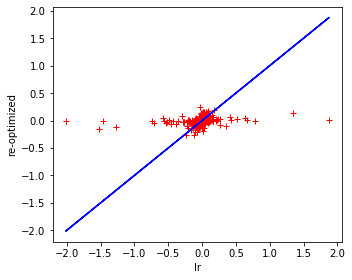

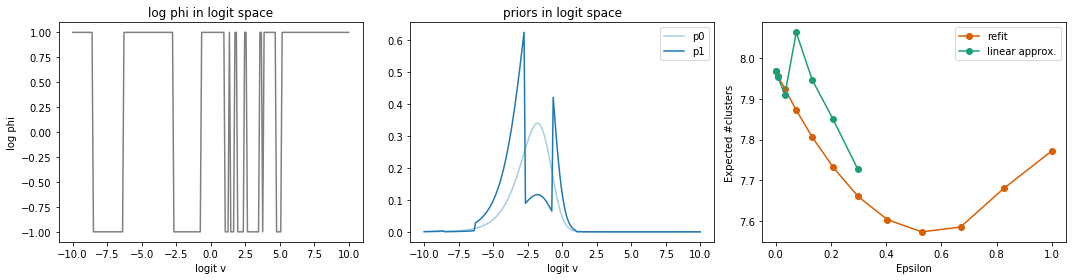

In [20]:
vb_refit_list, lr_list = plot_stuff('worst_case')[0:2]

In [21]:
def get_g_components(vb_free_params, vb_params_paragami): 
    e_ind_admix = get_e_ind_admix(vb_free_params, vb_params_paragami)
    return e_ind_admix 

#     vb_params_dict = vb_params_paragami.fold(vb_free_params, free = True)
    
#     stick_means = vb_params_dict['ind_admix_params']['stick_means']
#     stick_infos = vb_params_dict['ind_admix_params']['stick_infos']
    
#     e_sticks = \
#             ef.get_e_logitnormal(
#                 lognorm_means = stick_means,
#                 lognorm_infos = stick_infos,
#                 gh_loc = gh_loc,
#                 gh_weights = gh_weights)
    
#     return e_sticks

In [22]:
def plot_g_components(vb_refit_list, lr_list): 
    g_refit = get_g_components(vb_refit_list[-1], vb_params_paragami)
    g_lr = get_g_components(lr_list[-1], vb_params_paragami)
    g_init = get_g_components(vb_refit_list[0], vb_params_paragami)

    fig, ax = plt.subplots(2, 3, figsize = (12, 8)) 

    for k in range(6): 
        i = k // 3
        j = k % 3

        ax[i,j].set_title('k = {}'.format(k))
        print_diff_plot(g_lr[:, k],
                        g_refit[:, k], 
                        g_init[:, k], ax = ax[i,j])
        ax[i,j].set_xlabel('lr')
        ax[i,j].set_ylabel('refit')

    fig.tight_layout()

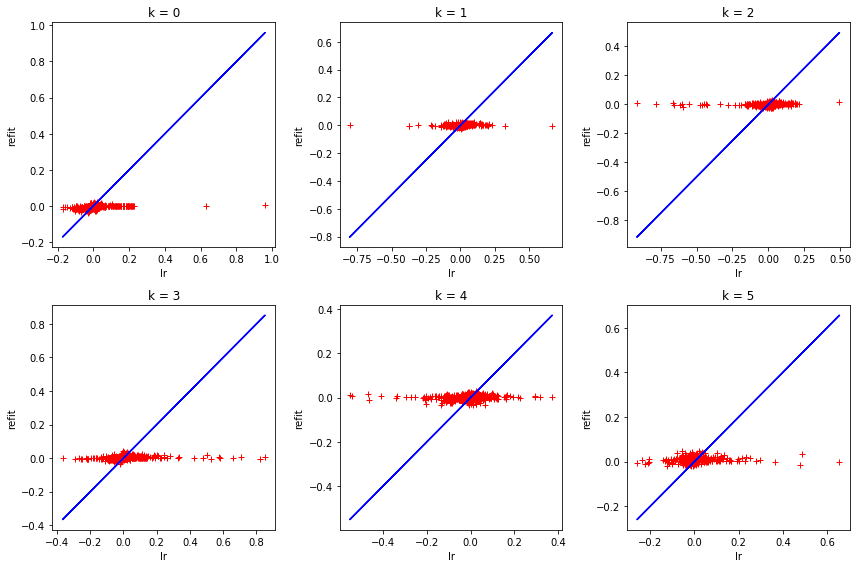

In [23]:
plot_g_components(vb_refit_list, lr_list)

In [37]:
fplotting_utils.plot_admixture(ind_admix)

TypeError: plot_admixture() missing 1 required positional argument: 'ax'

loading derivatives from:  ../fits/hgdp_fits/huang2011_fit_alpha6.0_lrderivatives.npz
Derivative time:  1132.8589177131653
CG tolerance:  1e-06
loading fit from:  huang2011_fit_sigmoidal1.npz
loading fit from:  huang2011_fit_sigmoidal10.npz
loading fit from:  huang2011_fit_sigmoidal0.npz
loading fit from:  huang2011_fit_sigmoidal7.npz
loading fit from:  huang2011_fit_sigmoidal9.npz
loading fit from:  huang2011_fit_sigmoidal4.npz
loading fit from:  huang2011_fit_sigmoidal3.npz
loading fit from:  huang2011_fit_sigmoidal2.npz
loading fit from:  huang2011_fit_sigmoidal5.npz
Derivative time: 1132.859secs
Optim time at epsilon = 1: 836.390secs


 30%|███       | 3/10 [00:00<00:00, 25.04it/s]

Computing expected number of clusters ... 


100%|██████████| 10/10 [00:00<00:00, 24.39it/s]


Plotting perturbation.
Loading influence function from:  ../fits/hgdp_fits/huang2011_fit_alpha6.0_lrderivatives.npz


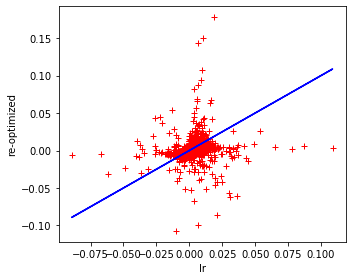

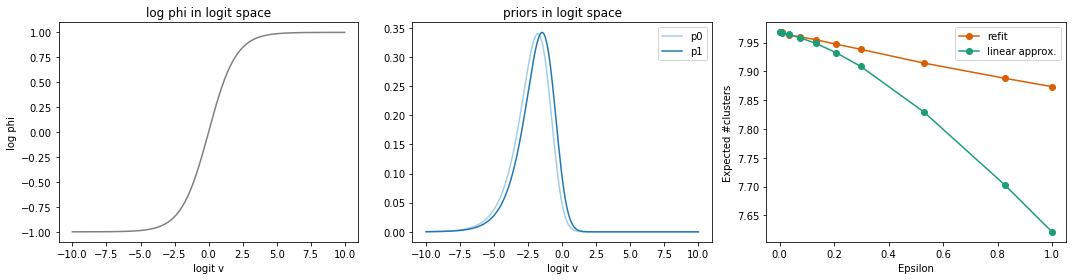

In [24]:
vb_refit_list, lr_list = plot_stuff('sigmoidal')[0:2]

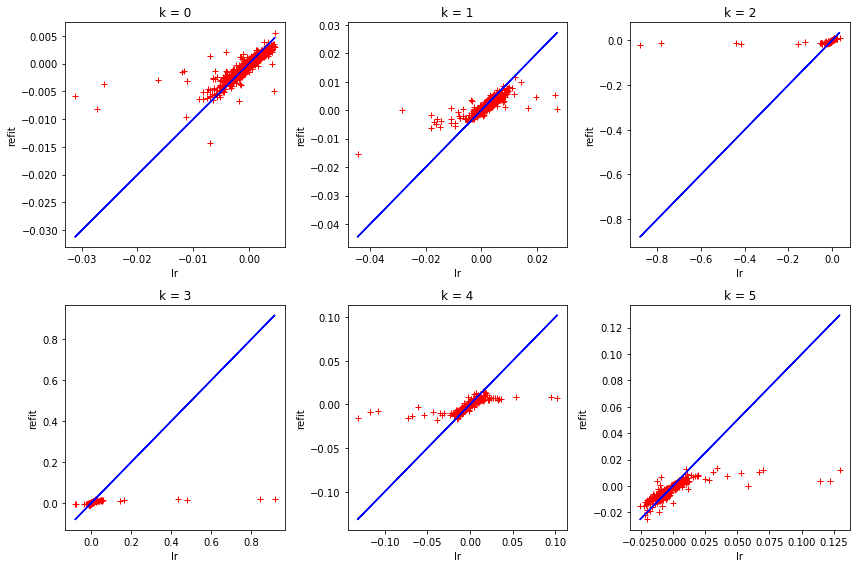

In [25]:
plot_g_components(vb_refit_list, lr_list)

loading derivatives from:  ../fits/hgdp_fits/huang2011_fit_alpha6.0_lrderivatives.npz
Derivative time:  1224.2629404067993
CG tolerance:  1e-06
loading fit from:  huang2011_fit_sigmoidal_neg8.npz
loading fit from:  huang2011_fit_sigmoidal_neg1.npz
loading fit from:  huang2011_fit_sigmoidal_neg6.npz
loading fit from:  huang2011_fit_sigmoidal_neg7.npz
loading fit from:  huang2011_fit_sigmoidal_neg0.npz
loading fit from:  huang2011_fit_sigmoidal_neg9.npz
loading fit from:  huang2011_fit_sigmoidal_neg3.npz
loading fit from:  huang2011_fit_sigmoidal_neg4.npz
loading fit from:  huang2011_fit_sigmoidal_neg10.npz
loading fit from:  huang2011_fit_sigmoidal_neg5.npz
loading fit from:  huang2011_fit_sigmoidal_neg2.npz
Derivative time: 1224.263secs
Optim time at epsilon = 1: 1946.779secs


 25%|██▌       | 3/12 [00:00<00:00, 26.49it/s]

Computing expected number of clusters ... 


100%|██████████| 12/12 [00:00<00:00, 27.38it/s]


Plotting perturbation.
Loading influence function from:  ../fits/hgdp_fits/huang2011_fit_alpha6.0_lrderivatives.npz


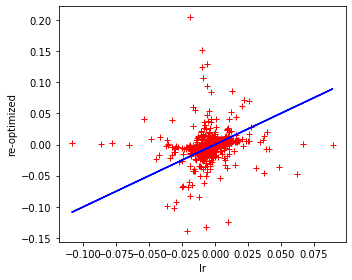

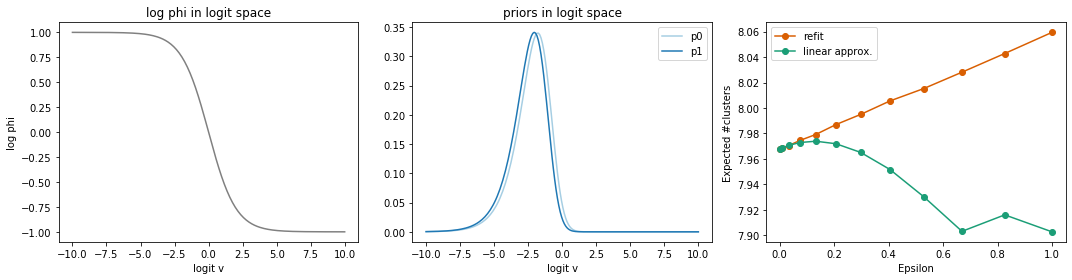

In [53]:
vb_refit_list, lr_list = plot_stuff('sigmoidal_neg')[0:2]

In [58]:
ind_admix = get_g_components(lr_list[-2], vb_params_paragami)    

In [59]:
k = ind_admix.shape[1]
k - np.sum(np.prod(1 - ind_admix, axis = 0))

DeviceArray(7.91603928, dtype=float64)

In [60]:
k - np.sum(np.exp(np.sum(np.log(1 - ind_admix), axis = 0)))

DeviceArray(7.91603928, dtype=float64)

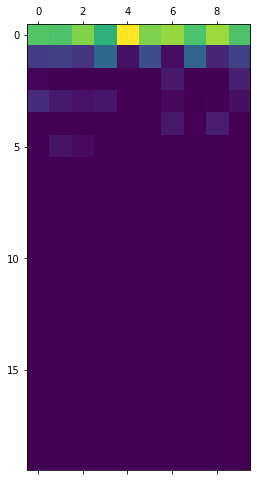

In [57]:
plt.matshow(ind_admix.transpose()[:, 0:10])

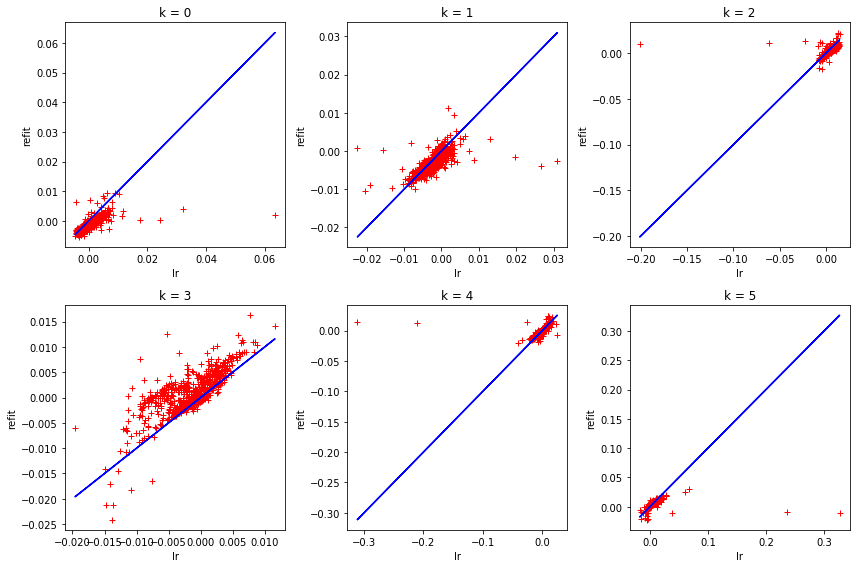

In [27]:
plot_g_components(vb_refit_list, lr_list)

loading derivatives from:  ../fits/hgdp_fits/huang2011_fit_alpha6.0_lrderivatives.npz
Derivative time:  1048.4064946174622
CG tolerance:  1e-06
loading fit from:  huang2011_fit_alpha_pert_pos2.npz
loading fit from:  huang2011_fit_alpha_pert_pos5.npz
loading fit from:  huang2011_fit_alpha_pert_pos10.npz
loading fit from:  huang2011_fit_alpha_pert_pos4.npz
loading fit from:  huang2011_fit_alpha_pert_pos3.npz
loading fit from:  huang2011_fit_alpha_pert_pos9.npz
loading fit from:  huang2011_fit_alpha_pert_pos0.npz
loading fit from:  huang2011_fit_alpha_pert_pos7.npz
loading fit from:  huang2011_fit_alpha_pert_pos1.npz
loading fit from:  huang2011_fit_alpha_pert_pos8.npz
Derivative time: 1048.406secs
Optim time at epsilon = 1: 1339.031secs


 27%|██▋       | 3/11 [00:00<00:00, 26.96it/s]

Computing expected number of clusters ... 


100%|██████████| 11/11 [00:00<00:00, 25.64it/s]


Plotting perturbation.
Loading influence function from:  ../fits/hgdp_fits/huang2011_fit_alpha6.0_lrderivatives.npz


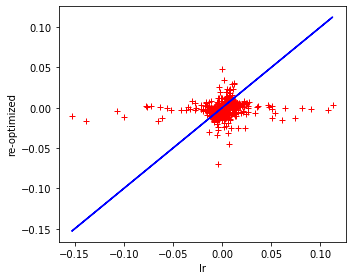

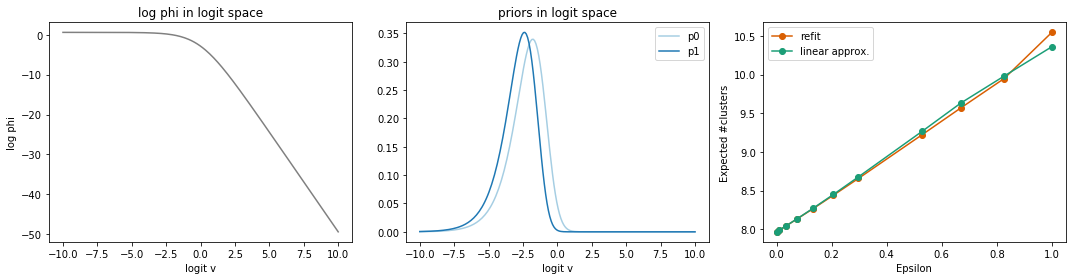

In [28]:
vb_refit_list, lr_list = plot_stuff('alpha_pert_pos')[0:2]

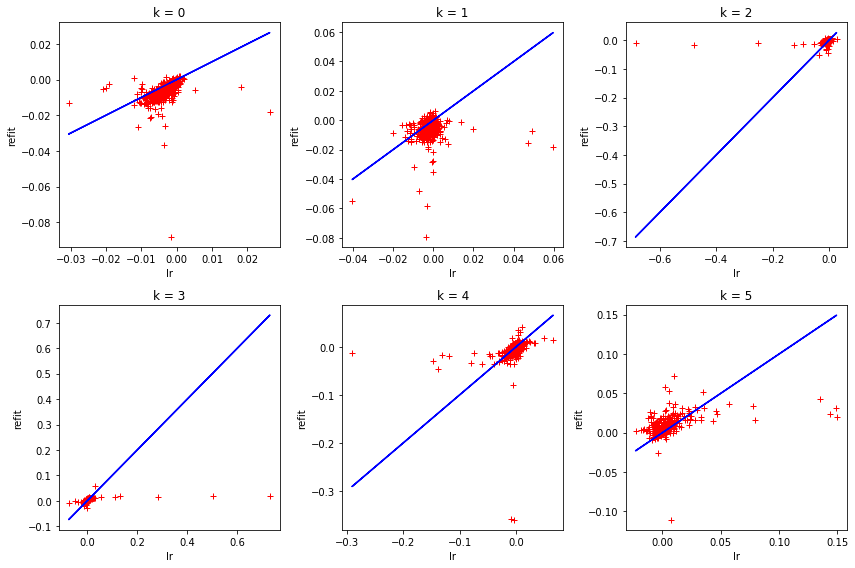

In [29]:
plot_g_components(vb_refit_list, lr_list)

loading derivatives from:  ../fits/hgdp_fits/huang2011_fit_alpha6.0_lrderivatives.npz
Derivative time:  1056.6242048740387
CG tolerance:  1e-06
loading fit from:  huang2011_fit_alpha_pert_neg8.npz
loading fit from:  huang2011_fit_alpha_pert_neg1.npz
loading fit from:  huang2011_fit_alpha_pert_neg6.npz
loading fit from:  huang2011_fit_alpha_pert_neg10.npz
loading fit from:  huang2011_fit_alpha_pert_neg7.npz
loading fit from:  huang2011_fit_alpha_pert_neg0.npz
loading fit from:  huang2011_fit_alpha_pert_neg9.npz
loading fit from:  huang2011_fit_alpha_pert_neg3.npz
loading fit from:  huang2011_fit_alpha_pert_neg4.npz
loading fit from:  huang2011_fit_alpha_pert_neg5.npz
loading fit from:  huang2011_fit_alpha_pert_neg2.npz
Derivative time: 1056.624secs
Optim time at epsilon = 1: 2914.872secs


 25%|██▌       | 3/12 [00:00<00:00, 28.05it/s]

Computing expected number of clusters ... 


100%|██████████| 12/12 [00:00<00:00, 27.63it/s]


Plotting perturbation.
Loading influence function from:  ../fits/hgdp_fits/huang2011_fit_alpha6.0_lrderivatives.npz


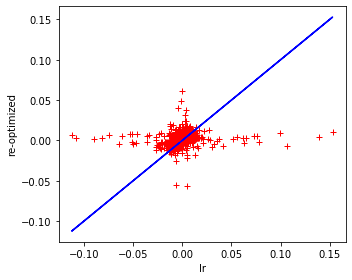

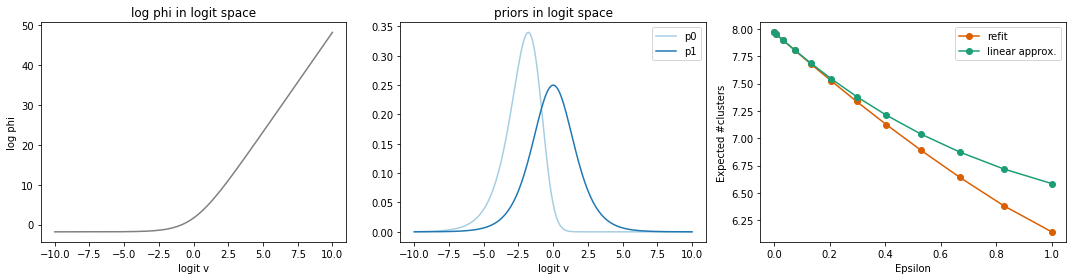

In [31]:
vb_refit_list, lr_list = plot_stuff('alpha_pert_neg')[0:2]

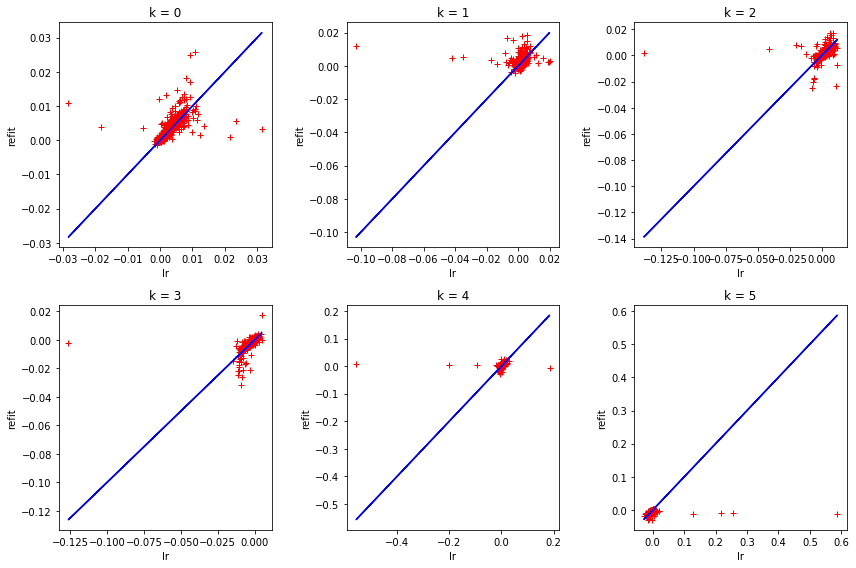

In [32]:
plot_g_components(vb_refit_list, lr_list)